In [1]:
import numpy as np
from warnings import warn
import matplotlib.pyplot as plt

In [2]:
def sweep_method(
    e: np.ndarray,
    d: np.ndarray,
    c: np.ndarray,
    b: np.ndarray
) -> np.ndarray:
    '''
    Метод прогонки для СЛАУ для трехдиагональных матриц, где
    d - элементы главной диагонали
    e - элементы над главной диагональю и последний 0
    c - элементы под главной диагональю и первый ноль
    b - неоднородность
    '''
    n = d.shape[0]
    for i in range(n):
        if i==0:
            if abs(d[i]) > abs(e[i]):
                print('Не выполнено достаточное условие сходимости метода прогонки')
                break
        if i==n-1:
            if abs(d[i]) > abs(c[i]):
                print('Не выполнено достаточное условие сходимости метода прогонки')
                break
        elif abs(d[i]) > abs(e[i]) + abs(c[i]):
            print('Не выполнено достаточное условие сходимости метода прогонки')
            break
    else:
        print('Достаточное условие сходимости метода прогонки выполнено')
        
    
    x = np.zeros_like(d)
    for k in range(1, n):
        d[k] = d[k] - e[k-1]*c[k]/d[k-1]
        b[k] = b[k] - b[k-1]*c[k]/d[k-1]
    x[n-1] = b[n-1]/d[n-1]
    for k in reversed(range(n-1)):
        x[k] = (b[k] - e[k]*x[k+1])/d[k]
    
    return x

In [3]:
def k(x):
    return np.sin(x) ** 2 + 1

def dk(x):
    return 2*np.sin(x)*np.cos(x)

def f(x):
    return np.exp(x)

def q(x):
    return np.cos(x)

kappa_0 = 1
g_0 = 1
kappa_1 = 1
g_1 = 1

In [4]:
def solve_approx(k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h = 0.1):
    X = np.arange(0, 1 + h/2, h)
    n = X.shape[0]
    D = q(X)
    PHI = f(X)
    KAPPA_0 = kappa_0 * (1 - (h/2) * (dk(0)/k(0))) + h/2 * q(0)
    G_0 = g_0 * (1 - (h/2) * (dk(0)/k(0))) + h/2 * f(0)
    KAPPA_1 = kappa_1*(1 + (h/2) * (dk(1)/ k(1))) + h/2 * q(1)
    G_1 = g_1*(1 + (h/2) * (dk(1)/ k(1))) + h/2 * f(1)
    
    # заполняем диагональные элементы
    diag_el = np.zeros(n)
    diag_el[0] = (-k(0)/h - KAPPA_0)
    diag_el[-1] = (-k(1)/h - KAPPA_1)
    for i in range(1, n-1):
        diag_el[i] = -(2*k(X[i]))/(h**2) - D[i]
    # заполняем элементы при y_i+1, тут нужно изменить нулевой
    up_diag = np.zeros(n)
    up_diag[0] = k(0)/h
    for i in range(1, n-1):
        up_diag[i] = k(X[i])/(h**2) + dk(X[i])/(2*h)
    # элементы при y_i-1, тут нужно изменить последний
    low_diag = np.zeros(n)
    low_diag[-1] = k(1) / h
    for i in range(1, n-1):
        low_diag[i] = k(X[i])/(h**2) - dk(X[i])/(2*h)
    # неоднородность уравнений
    neodnorodnost = np.zeros(n)
    neodnorodnost[0] = -G_0
    neodnorodnost[-1] = -G_1
    
    for i in range(1, n-1):
        neodnorodnost[i] = -PHI[i] 
        
    return X, sweep_method(up_diag, diag_el, low_diag, neodnorodnost)

In [5]:
def solve_balance(k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1):
    import numpy as np

    X = np.arange(0, 1 + h/2, h)
    n = X.shape[0]

    # Расчет коэффициентов k_i
    A = [k(x - 0.5 * h) for x in X]

    # Коэффициенты a_i = (2 * A_{i-1} * A_i) / (A_{i-1} + A_i)
    for i in range(1, n):
        A_prev = A[i - 1]
        A_curr = A[i]
        A[i] = (2 * A_prev * A_curr) / (A_prev + A_curr)

    # Расчет \varphi_i = 0.5 * (f_{i-0.5} + f_{i+0.5})
    PHI = np.zeros(n)
    for i in range(n):
        x_left = X[i] - 0.5 * h
        x_right = X[i] + 0.5 * h
        PHI[i] = 0.5 * (f(x_left) + f(x_right))
    # Начальные и конечные условия для PHI
    PHI[0] = 0.5 * (f(0) + f(h/2))
    PHI[-1] = 0.5 * (f(1 - h/2) + f(1))  # Исправил на 0.5, чтобы было симметрично

    # Расчет D_i = 0.5 * (q_{i-0.5} + q_{i+0.5})
    D = np.zeros(n)
    for i in range(n):
        x_left = X[i] - 0.5 * h
        x_right = X[i] + 0.5 * h
        D[i] = 0.5 * (q(x_left) + q(x_right))
    # Начальные и конечные условия для D
    D[0] = 0.5 * (q(0) + q(h/2))
    D[-1] = 0.5 * (q(1 - h/2) + q(1))

    # Формирование диагональной матрицы
    diag_el = np.zeros(n)
    # Первая строка (крайняя левая)
    diag_el[0] = -A[1]/h - (kappa_0 + h/2 * D[0])
    # Последняя строка (крайняя правая)
    diag_el[-1] = -A[-1]/h - (kappa_1 + h/2 * D[-1])
    # Внутренние строки
    for i in range(1, n - 1):
        diag_el[i] = -(A[i] + A[i + 1]) / (h ** 2) - D[i]

    # Верхняя диагональ
    up_diag = np.zeros(n)
    up_diag[0] = A[1] / h
    for i in range(1, n - 1):
        up_diag[i] = A[i + 1] / (h ** 2)

    # Нижняя диагональ
    low_diag = np.zeros(n)
    low_diag[-1] = A[-1] / h
    for i in range(1, n - 1):
        low_diag[i] = A[i] / (h ** 2)

    # Неоднородность
    neodnorodnost = np.zeros(n)
    neodnorodnost[0] = -g_0 - h * PHI[0] / 2
    neodnorodnost[-1] = -g_1 - h * PHI[-1] / 2
    for i in range(1, n - 1):
        neodnorodnost[i] = -PHI[i]

    # Решение системы
    return X, sweep_method(up_diag, diag_el, low_diag, neodnorodnost)

In [6]:
def solve_ritz(k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1):
    X = np.arange(0, 1 + h/2, h)
    n = X.shape[0]

    # Вычисляем A по формуле: a_i = 1/k_{i-0.5} - q_{i-0.5} * h^2/4
    A = np.zeros(n)
    for i in range(1, n):
        x_i = X[i]
        x_i_minus = x_i - h
        k_half = (k(x_i) + k(x_i - h)) / 2
        q_half = (q(x_i) + q(x_i - h)) / 2
        A[i] = 1 / k_half - q_half * (h ** 2) / 4

    # Вычисляем d_i = 0.5 * (q_{i-0.5} + q_{i+0.5})
    D = np.zeros(n)
    for i in range(1, n - 1):
        q_left = q(X[i] - h/2)
        q_right = q(X[i] + h/2)
        D[i] = 0.5 * (q_left + q_right)

    # Граничные значения для D
    D[0] = q(h/2)
    D[-1] = q(1 - h/2)

    # Вычисляем \varphi_i = 0.5 * (f_{i-0.5} + f_{i+0.5})
    PHI = np.zeros(n)
    for i in range(1, n - 1):
        f_left = f(X[i] - h/2)
        f_right = f(X[i] + h/2)
        PHI[i] = 0.5 * (f_left + f_right)

    # Граничные условия для PHI
    PHI[0] = f(h/2)
    PHI[-1] = f(1 - h/2)

    # Формирование диагональных элементов
    diag_el = np.zeros(n)
    diag_el[0] = -A[1]/h - (kappa_0 + h/2 * D[0])
    diag_el[-1] = -A[-1]/h - (kappa_1 + h/2 * D[-1])
    for i in range(1, n - 1):
        diag_el[i] = -(A[i] + A[i + 1]) / (h ** 2) - D[i]

    # Верхняя диагональ
    up_diag = np.zeros(n)
    up_diag[0] = A[1] / h
    for i in range(1, n - 1):
        up_diag[i] = A[i + 1] / (h ** 2)

    # Нижняя диагональ
    low_diag = np.zeros(n)
    low_diag[-1] = A[-1] / h
    for i in range(1, n - 1):
        low_diag[i] = A[i] / (h ** 2)

    # Неоднородность
    neodnorodnost = np.zeros(n)
    neodnorodnost[0] = -g_0 - h * PHI[0] / 2
    neodnorodnost[-1] = -g_1 - h * PHI[-1] / 2
    for i in range(1, n - 1):
        neodnorodnost[i] = -PHI[i]

    # Решение системы
    return X, sweep_method(up_diag, diag_el, low_diag, neodnorodnost)

## Аппроксимация

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


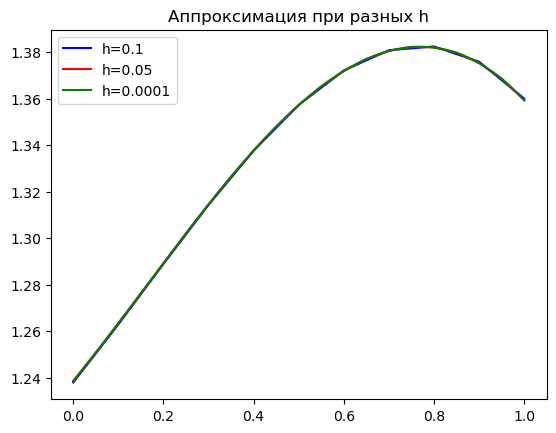

In [12]:
plt.plot(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='blue', label='h=0.1')
plt.plot(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='red', label='h=0.05')
plt.plot(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.0001
), color='green', label='h=0.0001')
plt.legend()
plt.title('Аппроксимация при разных h');

### Интегро-интерполяционный метод

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


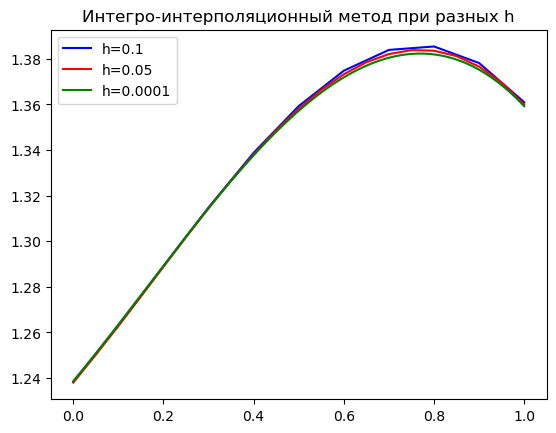

In [13]:
plt.plot(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='blue', label='h=0.1')
plt.plot(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='red', label='h=0.05')
plt.plot(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.0001
), color='green', label='h=0.0001')
plt.legend()
plt.title('Интегро-интерполяционный метод при разных h');

### Вариационно-разностный метод

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


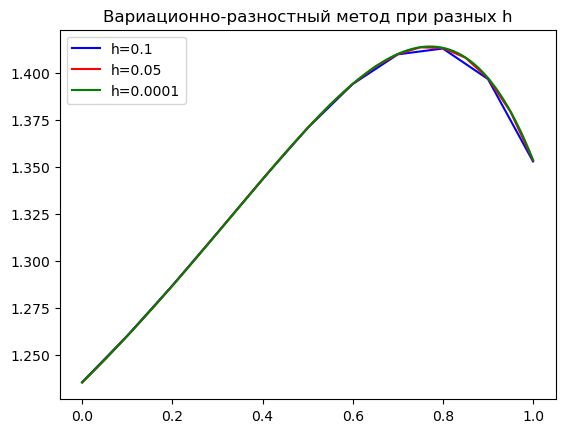

In [14]:
plt.plot(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='blue', label='h=0.1')
plt.plot(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='red', label='h=0.05')
plt.plot(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.0001
), color='green', label='h=0.0001')
plt.legend()
plt.title('Вариационно-разностный метод при разных h');

### Сравнение решений разными методами 

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


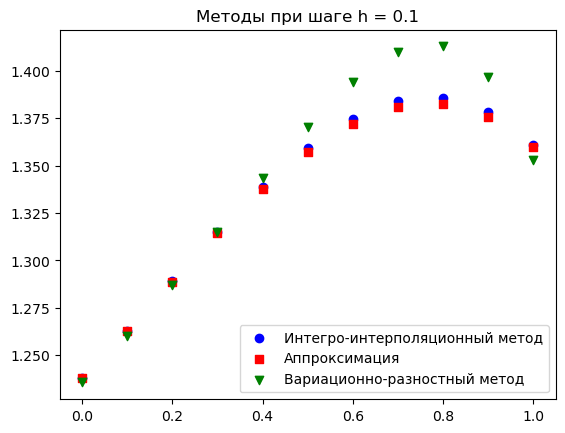

In [15]:
plt.scatter(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='b', label='Интегро-интерполяционный метод', marker='o')
plt.scatter(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='red', label='Аппроксимация', marker='s')
plt.scatter(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='g', label='Вариационно-разностный метод', marker='v')
plt.legend();
plt.title('Методы при шаге h = 0.1');

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


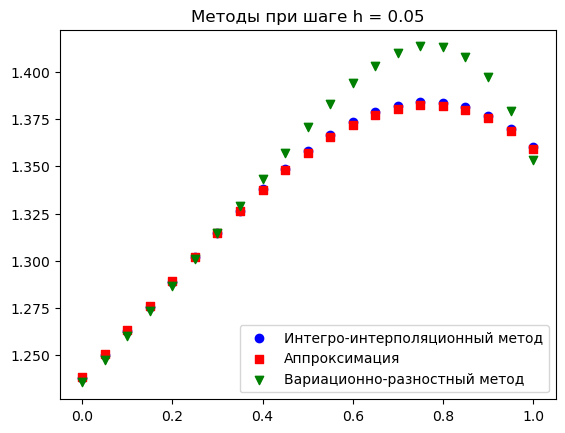

In [16]:
plt.scatter(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='b', label='Интегро-интерполяционный метод')
plt.scatter(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='red', label='Аппроксимация', marker='s')
plt.scatter(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.05
), color='g', label='Вариационно-разностный метод', marker='v')
plt.legend()
plt.title('Методы при шаге h = 0.05');

### Решение с точностью до 10^-7

In [25]:
np.set_printoptions(precision=7)

In [26]:
print('Аппроксимация:')
_, ap_sol = solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
)
print(ap_sol)
print('Интегро-интерполяционный метод:')
_, bal_sol = solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
)
print(bal_sol)
print('Вариационно-разностный метод:')
_, ritz_sol = solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
)
print(ritz_sol)

Аппроксимация:
Не выполнено достаточное условие сходимости метода прогонки
[1.2379302 1.2629129 1.2888937 1.3143138 1.3376024 1.3572963 1.3720898
 1.3808224 1.3824274 1.3758612 1.3600282]
Интегро-интерполяционный метод:
Не выполнено достаточное условие сходимости метода прогонки
[1.238143  1.262954  1.2889915 1.3148035 1.3387732 1.3592745 1.3747802
 1.3839091 1.3854177 1.3781538 1.3609867]
Вариационно-разностный метод:
Не выполнено достаточное условие сходимости метода прогонки
[1.2356461 1.2603087 1.2869549 1.3150005 1.3434399 1.3706125 1.3939504
 1.4097272 1.4128359 1.396628  1.3528562]


### Невязки с точным решением при h=10^-7

In [27]:
x, exact_sol = solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=10e-7
)

Не выполнено достаточное условие сходимости метода прогонки


In [28]:
ex_sol = exact_sol[::100000]

In [29]:
print('Точное решение:')
print(ex_sol)
print('Аппроксимация:')
print(abs(ap_sol - ex_sol))
print('Интегро-интерполяционный метод:')
print(abs(bal_sol - ex_sol))
print('Вариационно-разностный метод:')
print(abs(ritz_sol - ex_sol))

Точное решение:
[1.2386137 1.2634487 1.2892704 1.3145303 1.3376649 1.3572138 1.3718695
 1.3804675 1.3819352 1.3752229 1.3592283]
Аппроксимация:
[6.8354798e-04 5.3586560e-04 3.7672627e-04 2.1652631e-04 6.2545877e-05
 8.2551420e-05 2.2026396e-04 3.5487382e-04 4.9212463e-04 6.3832225e-04
 7.9992715e-04]
Интегро-интерполяционный метод:
[0.0004707 0.0004947 0.0002789 0.0002732 0.0011083 0.0020608 0.0029107
 0.0034415 0.0034824 0.0029309 0.0017585]
Вариационно-разностный метод:
[0.0029676 0.00314   0.0023154 0.0004703 0.005775  0.0133988 0.0220809
 0.0292597 0.0309006 0.0214052 0.0063721]


Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


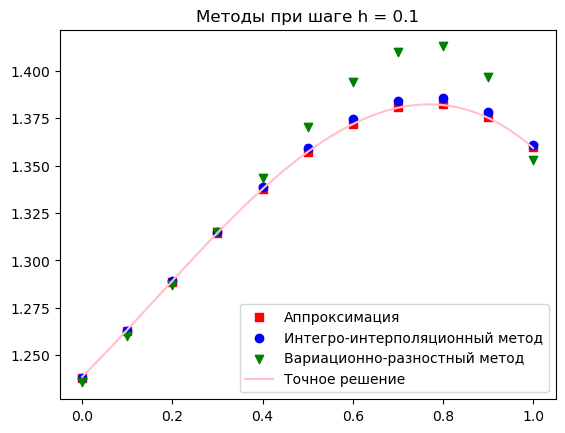

In [30]:
plt.scatter(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='red', label='Аппроксимация', marker='s')
plt.scatter(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='b', label='Интегро-интерполяционный метод', marker='o')
plt.scatter(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.1
), color='g', label='Вариационно-разностный метод', marker='v')
plt.plot(x, exact_sol, label = 'Точное решение', color='pink')
plt.legend();
plt.title('Методы при шаге h = 0.1');

### Поведение при уменьшении шага (h=0.01)

In [31]:
x, exact_sol = solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=10e-7
)

Не выполнено достаточное условие сходимости метода прогонки


In [35]:
ex_sol = exact_sol[::10000]

In [36]:
print('Аппроксимация:')
_, ap_sol = solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
)
print(ap_sol)
print('Интегро-интерполяционный метод:')
_, bal_sol = solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
)
print(bal_sol)
print('Вариационно-разностный метод:')
_, ritz_sol = solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
)
print(ritz_sol)

Аппроксимация:
Не выполнено достаточное условие сходимости метода прогонки
[1.2386072 1.2410052 1.2434258 1.2458677 1.2483296 1.2508102 1.253308
 1.2558217 1.2583499 1.260891  1.2634436 1.2660063 1.2685774 1.2711556
 1.2737391 1.2763266 1.2789163 1.2815068 1.2840964 1.2866837 1.2892669
 1.2918445 1.2944149 1.2969765 1.2995277 1.3020669 1.3045926 1.3071031
 1.309597  1.3120726 1.3145284 1.3169628 1.3193744 1.3217615 1.3241228
 1.3264567 1.3287618 1.3310365 1.3332795 1.3354893 1.3376645 1.3398037
 1.3419056 1.3439687 1.3459917 1.3479733 1.3499122 1.3518071 1.3536567
 1.3554597 1.3572148 1.358921  1.3605768 1.3621812 1.3637329 1.3652307
 1.3666736 1.3680603 1.3693896 1.3706606 1.371872  1.3730227 1.3741117
 1.3751379 1.3761001 1.3769973 1.3778285 1.3785925 1.3792884 1.379915
 1.3804713 1.3809564 1.381369  1.3817083 1.3819731 1.3821624 1.3822752
 1.3823105 1.3822671 1.3821441 1.3819404 1.3816549 1.3812866 1.3808345
 1.3802973 1.3796742 1.3789639 1.3781654 1.3772776 1.3762993 1.3752295
 1.3

### Невязки

In [37]:
print('Аппроксимация:')
print(abs(ap_sol - ex_sol))
print('Интегро-интерполяционный метод:')
print(abs(bal_sol - ex_sol))
print('Вариационно-разностный метод:')
print(abs(ritz_sol - ex_sol))

Аппроксимация:
[6.5467608e-06 6.4052787e-06 6.2659070e-06 6.1233661e-06 5.9789658e-06
 5.8333619e-06 5.6860126e-06 5.5367866e-06 5.3859499e-06 5.2338268e-06
 5.0803549e-06 4.9257469e-06 4.7700809e-06 4.6138546e-06 4.4569002e-06
 4.2991285e-06 4.1410154e-06 3.9823819e-06 3.8230175e-06 3.6633499e-06
 3.5035387e-06 3.3435855e-06 3.1838076e-06 3.0244581e-06 2.8653003e-06
 2.7062196e-06 2.5474076e-06 2.3890973e-06 2.2312646e-06 2.0741709e-06
 1.9178746e-06 1.7623171e-06 1.6073562e-06 1.4525450e-06 1.2987499e-06
 1.1458537e-06 9.9392747e-07 8.4242146e-07 6.9145801e-07 5.4163689e-07
 3.9263942e-07 2.4450835e-07 9.7324989e-08 4.9109345e-08 1.9473619e-07
 3.3945763e-07 4.8387367e-07 6.2750994e-07 7.7023216e-07 9.1233165e-07
 1.0539394e-06 1.1949608e-06 1.3354513e-06 1.4750373e-06 1.6139556e-06
 1.7522006e-06 1.8898762e-06 2.0268476e-06 2.1633698e-06 2.2995239e-06
 2.4354011e-06 2.5708438e-06 2.7056261e-06 2.8401056e-06 2.9744659e-06
 3.1086272e-06 3.2427735e-06 3.3771416e-06 3.5114792e-06 3.645

Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки
Не выполнено достаточное условие сходимости метода прогонки


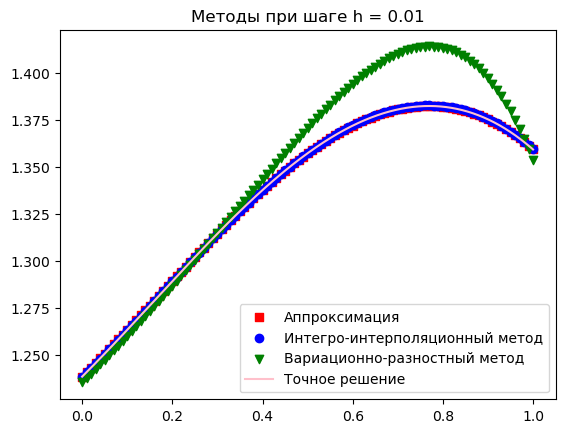

In [38]:
plt.scatter(*solve_approx(
    k, dk, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
), color='red', label='Аппроксимация', marker='s')
plt.scatter(*solve_balance(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
), color='b', label='Интегро-интерполяционный метод', marker='o')
plt.scatter(*solve_ritz(
    k, q, f, kappa_0, g_0, kappa_1, g_1, h=0.01
), color='g', label='Вариационно-разностный метод', marker='v')
plt.plot(x, exact_sol, label = 'Точное решение', color='pink')
plt.legend();
plt.title('Методы при шаге h = 0.01');